# Natural Language Processing - Apple Sentiment
by Michael Kearns

# Business Understanding

Customer relations and approval is highly valued at the Tech Sales Company (TSC). Currently, TSC sells Apple products and we want to be sure if we should continue to market and supply Apple products to our customers. If customers no longer like Apple, we want to separate ourselves from the brand and show our loyalty to the customers and promote other products. To determine if customers support Apple, we plan to develop a natural language processing model that can identify customer sentiment toward Apple based on the content of X (Twitter) posts. Then, this model will be used to monitor customer sentiment over the next year by rating future X posts.

# Data Understanding
To train and test this machine learning model, data from [Crowdflower](https://www.kaggle.com/datasets/slythe/apple-twitter-sentiment-crowdflower) will be used. This dataset includes nearly 4,000 X posts that reference Apple from December, 2014. The primary features that will be used are the "Sentiment" and "Text" features that include the posts and that user's sentiment toward Apple, rated from 1-3 scale


## Data Preparation

In [1]:
import pandas as pd

#import csv file
filename = 'data/Apple-Twitter-Sentiment-DFE.csv'
df = pd.read_csv(filename, encoding="latin1")

#check dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3886 entries, 0 to 3885
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   _unit_id              3886 non-null   int64  
 1   _golden               3886 non-null   bool   
 2   _unit_state           3886 non-null   object 
 3   _trusted_judgments    3886 non-null   int64  
 4   _last_judgment_at     3783 non-null   object 
 5   sentiment             3886 non-null   object 
 6   sentiment:confidence  3886 non-null   float64
 7   date                  3886 non-null   object 
 8   id                    3886 non-null   float64
 9   query                 3886 non-null   object 
 10  sentiment_gold        103 non-null    object 
 11  text                  3886 non-null   object 
dtypes: bool(1), float64(2), int64(2), object(7)
memory usage: 337.9+ KB


Only the "sentiment" and "text" columns will be retained for this model. All other columns can be removed.

In [2]:
#Keep relevant columns in dataset.
df = df[['sentiment','text']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3886 entries, 0 to 3885
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  3886 non-null   object
 1   text       3886 non-null   object
dtypes: object(2)
memory usage: 60.8+ KB


In [3]:
#Check overall sentiment distribution
print(df['sentiment'].value_counts())

sentiment
3               2162
1               1219
5                423
not_relevant      82
Name: count, dtype: int64


Based on background information provided by the datasource, sentiment is ranked as 1 - Negative, 3 - Neutral, 5 - Positive.

In [4]:
#Check proportion of sentiment values
print(df['sentiment'].value_counts(normalize = True))

sentiment
3               0.556356
1               0.313690
5               0.108852
not_relevant    0.021101
Name: proportion, dtype: float64


"Neutral" sentiment posts take up almost 56% of the datset, followed by %31 "Negative" posts, and %11 "Positive" posts. If the model was created based on this current distribution, the model would likely be more influenced by the "Neutral" or "Negative" posts and will not be able to accurately rate future posts. Therefore, some tactics will need to be implemented to deal with the class imbalance. Before the class imbalance is addressed, the data will need to be cleaned/preprocessed and split into train and test sets.

There are less than 100 posts labeled as "not_relevant". These can be removed and will not be considered in the model.

In [5]:
#Remove "not_relevant" rows
df = df[df['sentiment']!= 'not_relevant']

#Recheck proportion of sentiment values and confirm "not_relevant" rows are removed
print(df['sentiment'].value_counts(normalize = True))

sentiment
3    0.568349
1    0.320452
5    0.111199
Name: proportion, dtype: float64


In [6]:
#convert sentiment to integers
df['sentiment'] = df['sentiment'].astype(int)

Data needs to simplified and cleaned. Initial steps to preprocess the text will be to convert all letters in a post to lowercase. Mentiones, ie. @..., and URLS will be removed. The user mentions will be primarily directed at Apple which is not signifcant as all posts in this data are in reference towards Apple. URLS are long and not semantic content.

In [7]:
#Convert all letters to lowercase
df['text_cleaned'] = df['text'].str.lower()

import re

def clean_text(text):
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'#', '', text)  # Remove hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = text.strip()  # Remove extra whitespaces
    return text

# Apply function to the dataset
df['text_cleaned'] = df['text_cleaned'].apply(clean_text)

In [8]:
#confirm that cleaning worked.
df[['text','text_cleaned']].iloc[500]

text            #AAPL moving towards the #IoT and more connect...
text_cleaned    aapl moving towards the iot and more connectiv...
Name: 516, dtype: object

# Exploratory Data Analysis

To make the text more suitable for a machine learning model, the text needs to be tokenized. This will be done using the **nltk** module.

In [9]:
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
import matplotlib.pyplot as plt
import string


/Users/michaelkearns/anaconda3/envs/my-learn-env/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [10]:
#tokenize text using basic regex pattern
token_pattern = r"(?u)\b\w\w+\b"
tokenizer = RegexpTokenizer(token_pattern)

df['text_tokenized']=df['text_cleaned'].apply(tokenizer.tokenize)

In [11]:
#confirm that tokenizing worked
df[['text','text_cleaned','text_tokenized']].iloc[500]

text              #AAPL moving towards the #IoT and more connect...
text_cleaned      aapl moving towards the iot and more connectiv...
text_tokenized    [aapl, moving, towards, the, iot, and, more, c...
Name: 516, dtype: object

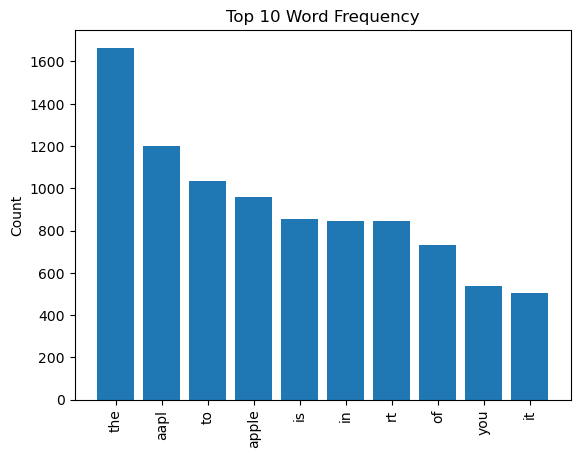

In [12]:
#Create Frequency Distribution of Tokens
text_freq_dist = FreqDist(df['text_tokenized'].explode())

# Plot the top 10 tokens

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def visualize_top_10(freq_dist, title):

    # Extract data for plotting
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]

    # Set up plot and plot data
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)
    
visualize_top_10(text_freq_dist, 'Top 10 Word Frequency')

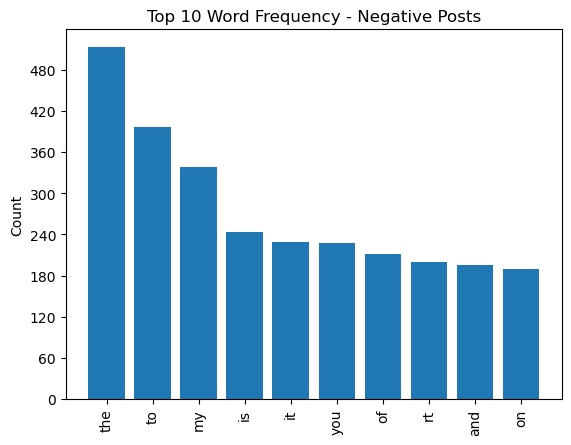

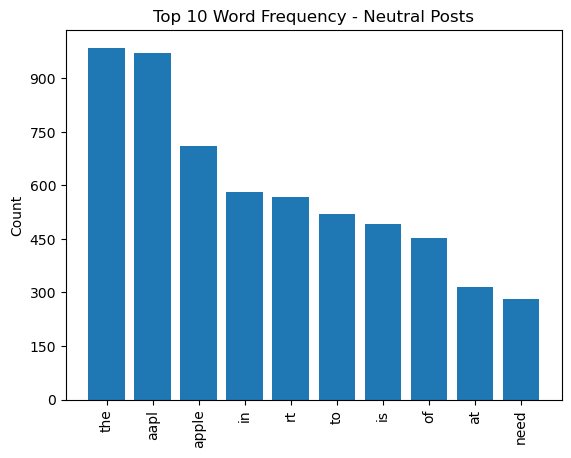

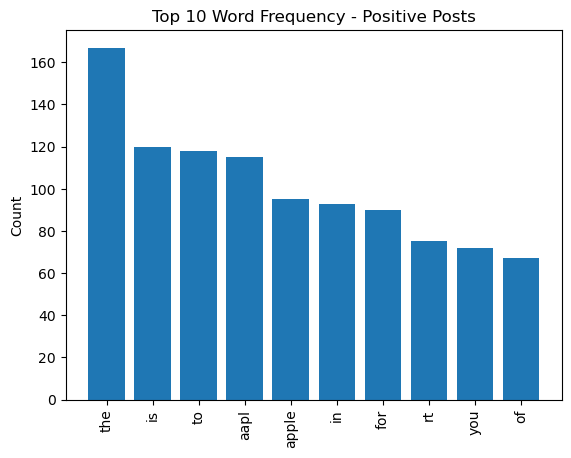

In [13]:
# Add in labels for filtering (we won't pass them in to the model)
def visualize_top_ten_tokens_per_sentiment(sentiment,rating,text):
    freq_dist = FreqDist(df[df[sentiment] == rating][text].explode())
    if rating == 1:
        title = 'Top 10 Word Frequency - Negative Posts'
    elif rating == 3:
        title = 'Top 10 Word Frequency - Neutral Posts'
    else: title = 'Top 10 Word Frequency - Positive Posts'

    return  visualize_top_10(freq_dist, title)

for i in range(1, 7, 2):
    visualize_top_ten_tokens_per_sentiment('sentiment',i,'text_tokenized')
    

Stopwords seem to be very repeatable among the three types of posts. They should me removed to make the tokens more distinct.

In [14]:
#download stopwords to remove
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords

stopwords_list = stopwords.words('english')
#'aapl' and 'apple' will be very repetive in these posts so they will be removed.
stopwords_list.append('apple')
stopwords_list.append('aapl')
stopwords_list.append('rt')

def remove_stopwords(token_list):
    stopwords_delete = [token for token in token_list if token not in stopwords_list]
    return stopwords_delete

df['text_stopwords_removed'] = df['text_tokenized'].apply(remove_stopwords)

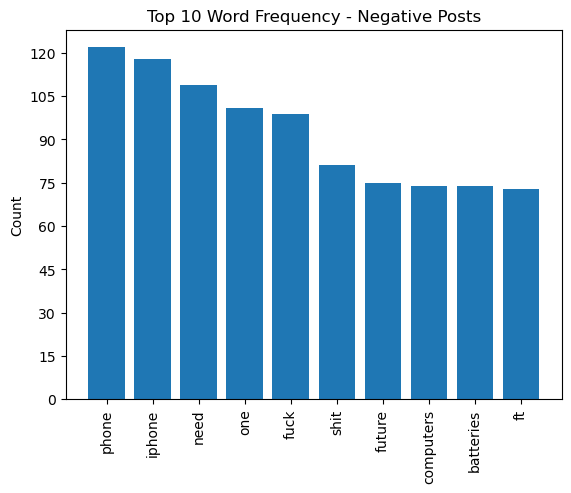

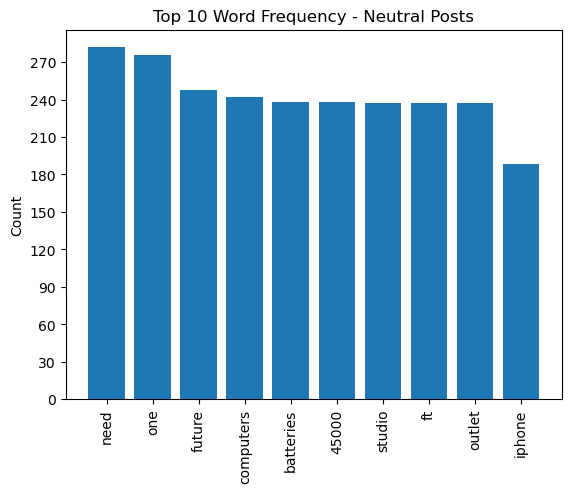

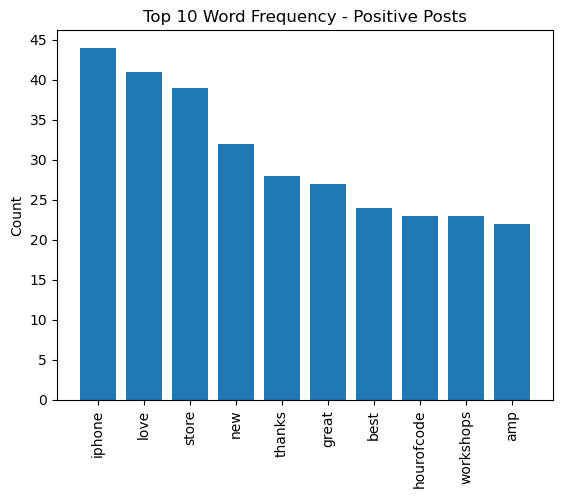

In [15]:
for i in range(1, 7, 2):
    visualize_top_ten_tokens_per_sentiment('sentiment',i,'text_stopwords_removed')

# Modeling

In [16]:
print (df['sentiment'].value_counts(normalize = True))

sentiment
3    0.568349
1    0.320452
5    0.111199
Name: proportion, dtype: float64


With this class imbalance, lets convert to a binary problem. Neutural posts could be somewhat postive and somewhat negative. So we will randomly split this the neutral posts so and reassign them to Negative and Netural categories so that they are more balanced.

In [17]:
from sklearn.model_selection import train_test_split

y = df['sentiment']
X = df.drop('sentiment',axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 30)

In [ ]:
print(y_train.value_counts())
print(y_train.value_counts(normalize = True))

In [ ]:
# Import the relevant vectorizer class
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate a vectorizer with max_features=10
# (we are using the default token pattern)
tfidf = TfidfVectorizer(max_features=10)

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train['text'])

# Visually inspect the 10 most common words
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names_out())

## Baseline Model 

For the baseline Model a Logistic Regression Model will be used. For this case, 

# Conclusion

## Limitations

## Recommendations

## Next Steps